# Fine-tuning GPT-2 for text classification
Stefan/Yuzhao Heng
Since Wed. Feb. 9th, 2022


Reproduce the results in paper [Zero-shot Text Classification With Generative Language Models](https://arxiv.org/abs/1912.10165),
since the authors didn't release the code.

Serve as infrastructure and baseline for project on efficient and accurate encoder for text classification with many labels.


## Notebook Setup



In [1]:
%load_ext autoreload
%autoreload 2



## Colab Setup



In [2]:
import os
import sys


if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')

    ! pip3 install icecream datasets

    # base_path = '/content/drive/My Drive//Research/'
    # os.chdir(os.path.join(base_path, 'Unified Encoder/Unified-Encoder'))

    sys.path.append(os.path.join('drive', 'My Drive', 'Research', 'Unified Encoder', 'Unified-Encoder'))


from unified_encoder.util import *
print(PATH_BASE)  # Sanity check, should be the path appended if Colab



/Users/stefanh/Documents/UMich/Research/Clarity Lab/Unified Encoder


## Setup



In [3]:
import random

import numpy as np
import torch
import transformers
from transformers import AutoTokenizer, AutoModel
from transformers import TrainingArguments, Trainer, SchedulerType
from datasets import load_dataset
from icecream import ic

from unified_encoder.baseline import gpt2


rcParams['figure.dpi'] = 200
rcParams['font.size'] = 6



## Seed setup



In [4]:
if torch.cuda.is_available():
    os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'  # Required for some CuBLAS operations
    ! echo $CUBLAS_WORKSPACE_CONFIG


seed = config('random-seed')
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.use_deterministic_algorithms(True)

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(seed)
transformers.set_seed(seed)



## Prep Model & Dataset for training


Using custom data configuration default
Reusing dataset ag_news (/Users/stefanh/.cache/huggingface/datasets/ag_news/default/0.0.0/bc2bcb40336ace1a0374767fc29bb0296cdaf8a6da7298436239c54d79180548)


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

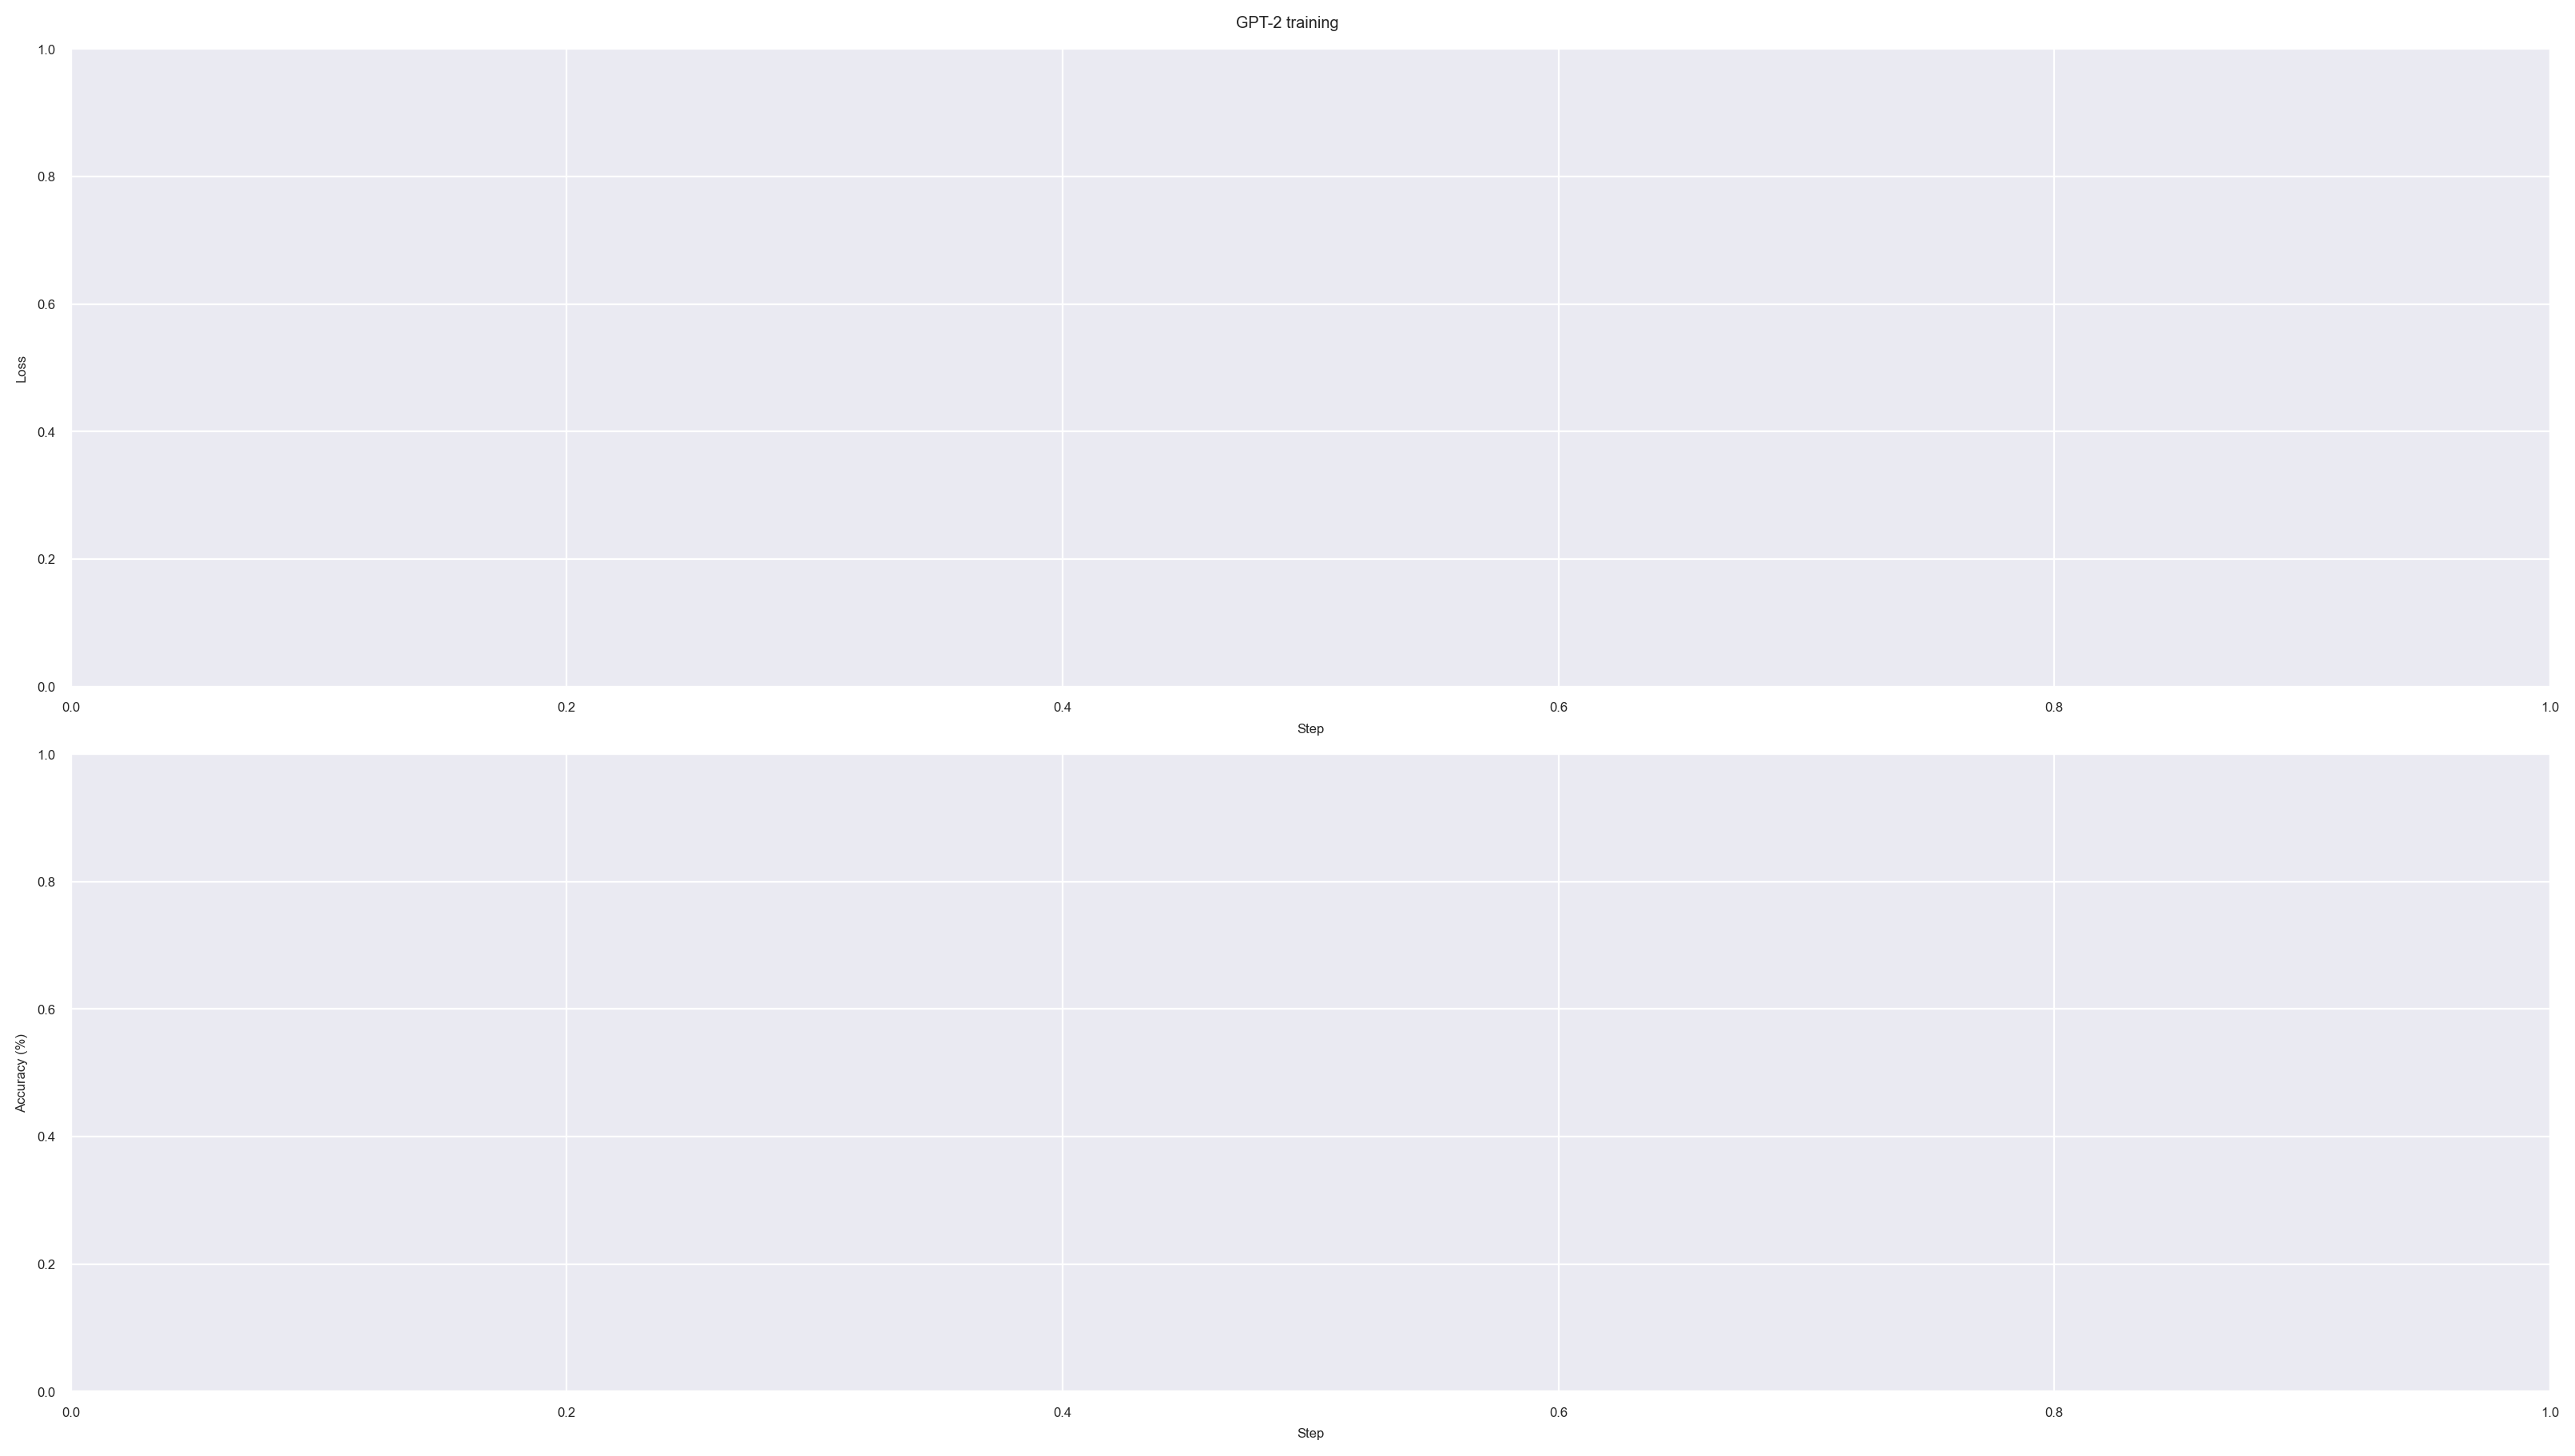

NameError: name 'ic' is not defined

In [5]:
nm = 'debug'
model, tokenizer, data_collator = gpt2.get_model_n_tokenizer(nm)
train_args = gpt2.get_train_setup(nm)

def tokenize_func(sample):
    ret = tokenizer(sample['text'], padding='max_length', truncation=True)
    return ret
dset_tr, dset_vl = gpt2.get_dset(map_func=tokenize_func, remove_columns=['label', 'text'], n_sample=8, random_seed=seed)

trainer = gpt2.CustomTrainer(
    model=model,
    args=train_args,
    data_collator=data_collator,
    train_dataset=dset_tr,
    eval_dataset=dset_vl,
    compute_metrics=gpt2.compute_metrics
)
cb = gpt2.MyLoggingCallback(trainer, interactive=False)
trainer.add_callback(cb)



## Train


In [ ]:
trainer.train()



## Evaluate


In [ ]:
cb.set_mode('eval')
ic(trainer.evaluate())

